# Classification Project

## Predicting Salary Group based on a survey.

### Importing all the libraries required

In [6]:
# !pip install torch torchvision torchaudio
# !pip install torch-geometric
# !pip install pandas networkx
# !pip install geonamescache
import pandas as pd
import re
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import torch
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import geonamescache
import seaborn as sns
import torch
import nltk
import subprocess
import time
from nltk.corpus import wordnet
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Importing the main dataset

In [7]:
df = pd.read_csv('SURVEY.csv')

In [8]:
print("There are " , len(df), " rows in this dataset")
df.columns

There are  28008  rows in this dataset


Index(['Timestamp', 'How old are you?', 'What industry do you work in?',
       'Job title',
       'If your job title needs additional context, please clarify here:',
       'What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)',
       'How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.',
       'Please indicate the currency',
       'If "Other," please indicate the currency here: ',
       'If your income needs additional context, please provide it here:',
       'What country do you work in?',
       'If you're in the U.S., what state do you work in?',
       'What city do you work in?',
       'How many years of professional work experience do you have overall?',
       

In [9]:
df.head()

,Timestamp,How old are you?,What industry do you work in?,Job title,"If your job title needs additional context, please clarify here:","What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)","How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.",Please indicate the currency,"If ""Other,"" please indicate the currency here:","If your income needs additional context, please provide it here:",What country do you work in?,"If you're in the U.S., what state do you work in?",What city do you work in?,How many years of professional work experience do you have overall?,How many years of professional work experience do you have in your field?,What is your highest level of education completed?,What is your gender?,What is your race? (Choose all that apply.)
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


### Data cleaning and preprocessing

In [10]:
# Renaming the columns to make it easier to code and to view
short_names = {
    'How old are you?': 'age',
    'What industry do you work in?': 'industry',
    'Job title': 'job_title',
    "What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)": 'annual_salary',
    'How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.' : 'add_compensation',
    'Please indicate the currency': 'currency',
    'If your job title needs additional context, please clarify here:': 'Additional Context',
    'If "Other," please indicate the currency here: ': 'other_currency',
    'What country do you work in?': 'country',
    'If you\'re in the U.S., what state do you work in?': 'state',
    'What city do you work in?': 'city',
    'If your income needs additional context, please provide it here:':'income_context',
    'How many years of professional work experience do you have overall?': 'total_exp',
    'How many years of professional work experience do you have in your field?': 'field_exp',
    'What is your highest level of education completed?': 'education_level',
    'What is your gender?': 'gender',
    'What is your race? (Choose all that apply.)': 'race'
}

# Rename columns in-place
df.rename(columns=short_names, inplace=True)

# Print the modified column names
print(df.columns)

Index(['Timestamp', 'age', 'industry', 'job_title', 'Additional Context',
       'annual_salary', 'add_compensation', 'currency', 'other_currency',
       'income_context', 'country', 'state', 'city', 'total_exp', 'field_exp',
       'education_level', 'gender', 'race'],
      dtype='object')


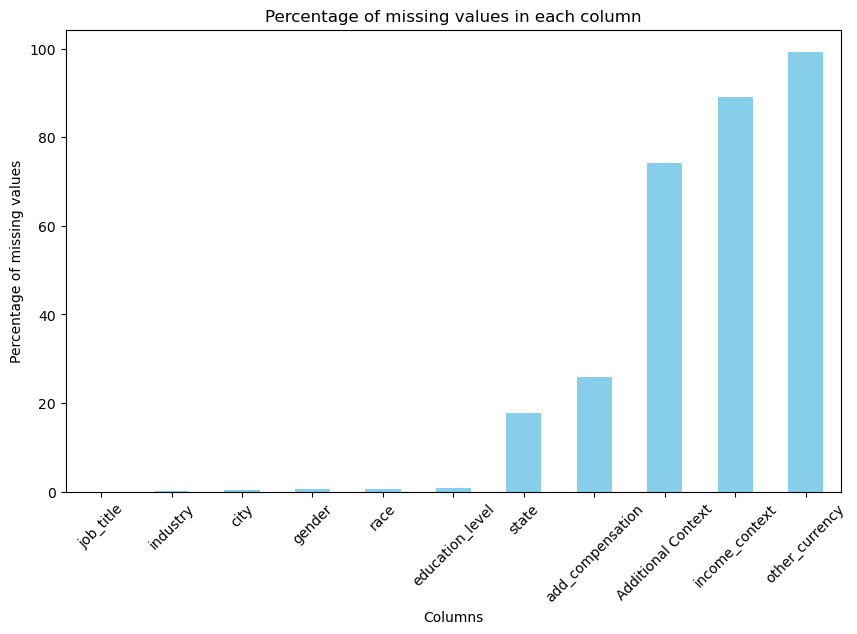

In [11]:
# Calculuting the % of missing values in each column
missing_data = df.isnull().mean() * 100
missing_data = missing_data[missing_data > 0]  # Filter columns with missing values
missing_data.sort_values(inplace=True) # Sort them 

# Visualization of the missing data
plt.figure(figsize=(10, 6))
missing_data.plot(kind='bar', color='skyblue') # Barchart with blue color
plt.ylabel('Percentage of missing values')
plt.xlabel('Columns')
plt.title('Percentage of missing values in each column')
plt.xticks(rotation=45)
plt.show()

In the provided code, we compute the percentage of missing values for each column in the dataset. Upon examination, we find that three columns—'Additional context,' 'income_context,' and 'other_currency'— have missing values exceeding 70%. Typically, columns with such a high percentage of missing values might be considered for removal from the dataset. However, in the case of 'other_currency,' there may be valuable information associated with it. Therefore, instead of outright dropping it, we decide to keep the 'other_currency' column and explore potential strategies to utilize its data effectively in subsequent analyses.

In [12]:
# We drop timestamp here too because its the time the data was submitted (unimportant)
df= df.drop(columns=['Timestamp','Additional Context', 'income_context'])

print(df.columns)

Index(['age', 'industry', 'job_title', 'annual_salary', 'add_compensation',
       'currency', 'other_currency', 'country', 'state', 'city', 'total_exp',
       'field_exp', 'education_level', 'gender', 'race'],
      dtype='object')


#### Exploring and Visualizing the data.

#### Age

Let us get introduced to our data, by visualizing it and exploring its many instances, but first, let us start with the attribute "age" and explore how many instances each value of age has.

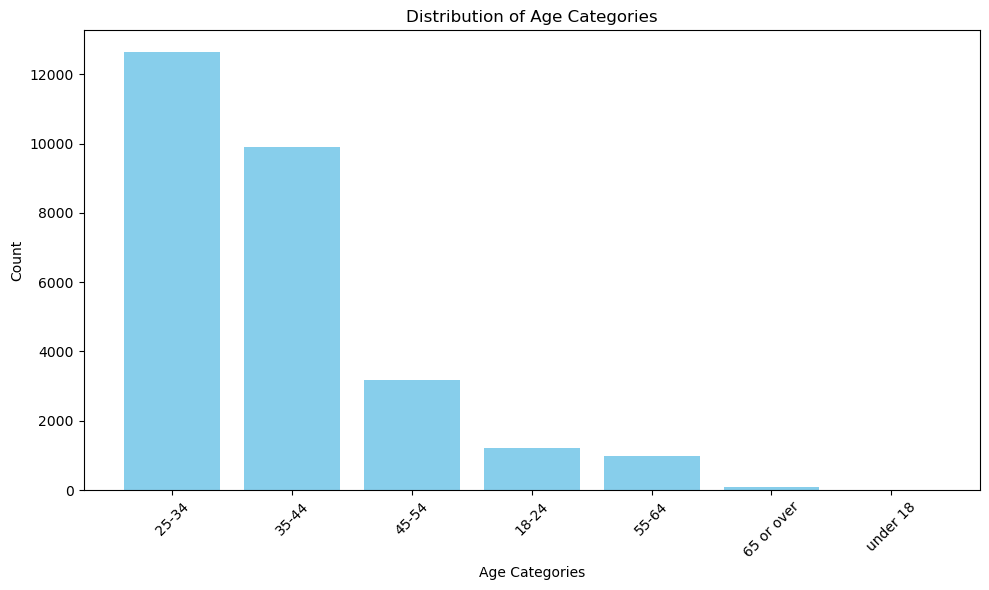

In [13]:
# Extract unique age categories from the DataFrame
age_categories = df['age'].unique()

# Count occurrences of each age category
age_counts = df['age'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values, color='skyblue')

# Adding labels and title
plt.xlabel('Age Categories')
plt.ylabel('Count')
plt.title('Distribution of Age Categories')

# Show plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This shows us that the majority of people who filled this survey are between the ages of 25-44, while virtually no children or seniors have filled it in, therefore, our findings will mostly target the ages this model is trained upon, those between 18-64.

#### Industry

In [14]:
print(len(df['industry'].unique()))

1218


Since we have too many unique values to be able to plot them without confusing the reader, we have decided to print the top 15 industries that occur in our dataset!

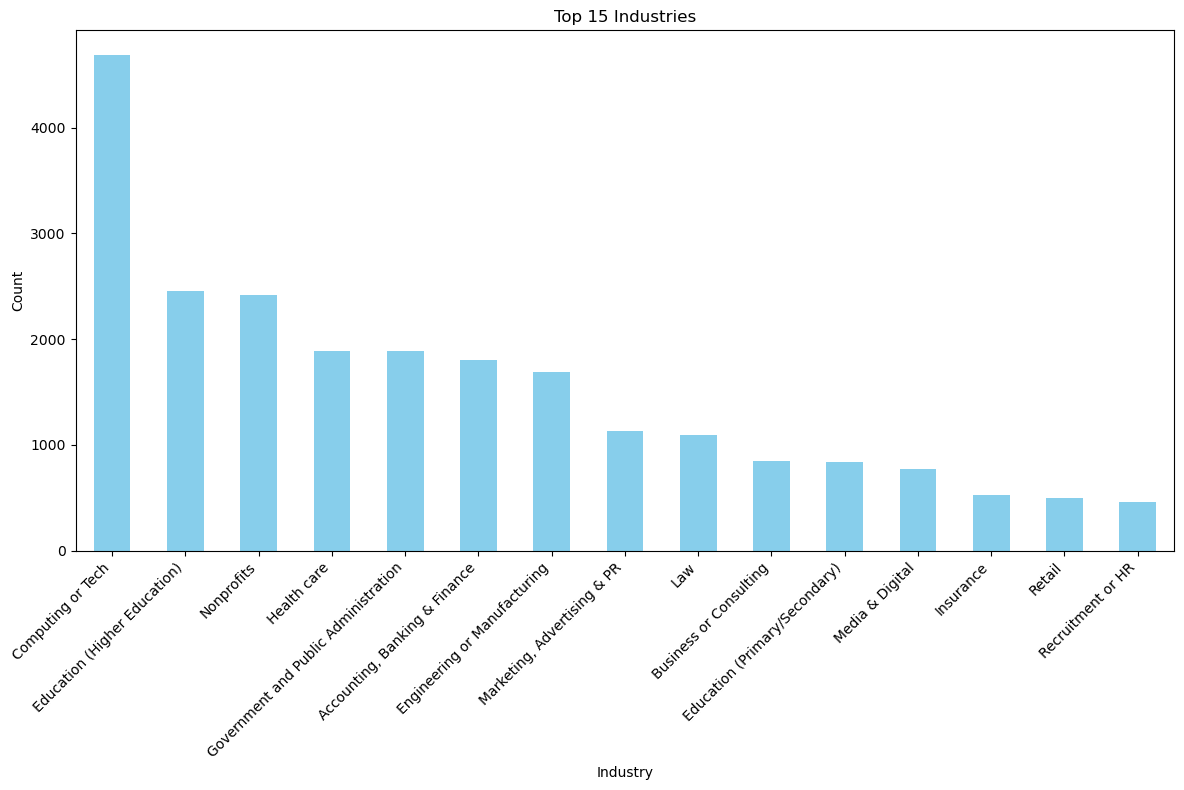

In [15]:
industry_counts = df['industry'].value_counts()

# Sort the counts in descending order and select top 15 instances
top_industries = industry_counts.head(15)

# Create a bar chart
plt.figure(figsize=(12, 8))
top_industries.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Industry')
plt.ylabel('Count')
plt.title('Top 15 Industries')

# Show plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

The survey results indicate that the majority of respondents who participated were individuals affiliated with the computing or technology industry.

#### State

In the survey provided, you are able to enter more than one state, however, we decided to take the first state as the primary state, so we extract it by splitting it, and creating a new attribute called first_state and plotting it!

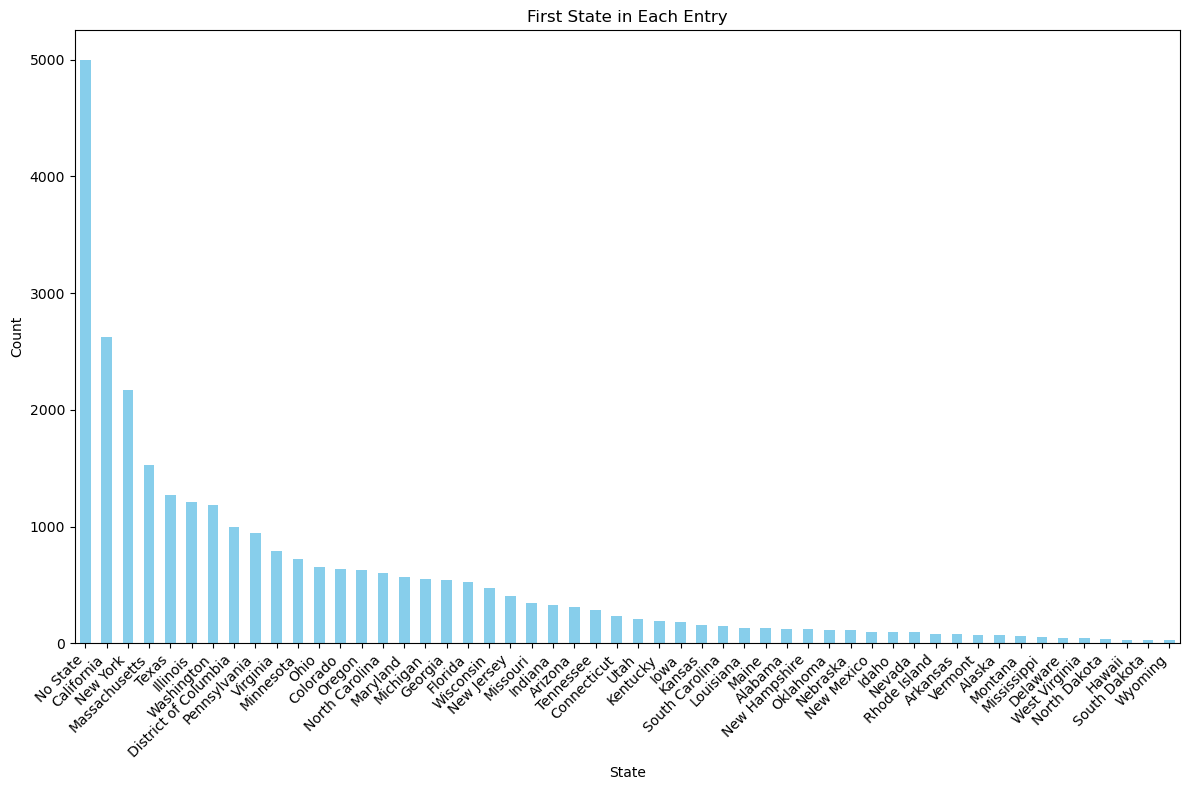

In [16]:
df['first_state'] = df['state'].str.split(', ').str[0]

# Step 2: Handle missing values in 'first_state'
df['first_state'] = df['first_state'].fillna('No State')

# Count occurrences of each unique first state
state_counts = df['first_state'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 8))
state_counts.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Count')
plt.title('First State in Each Entry')

# Show plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This shows that the majority of people do not have a state affiliated with their work, this is expected, as this survey was not limited to Americans.

#### City

In [17]:
print(len(df['city'].unique()))

4810


Since city also has many unique values, we also print the top 15 cities, as fitting all of them would look irregular.

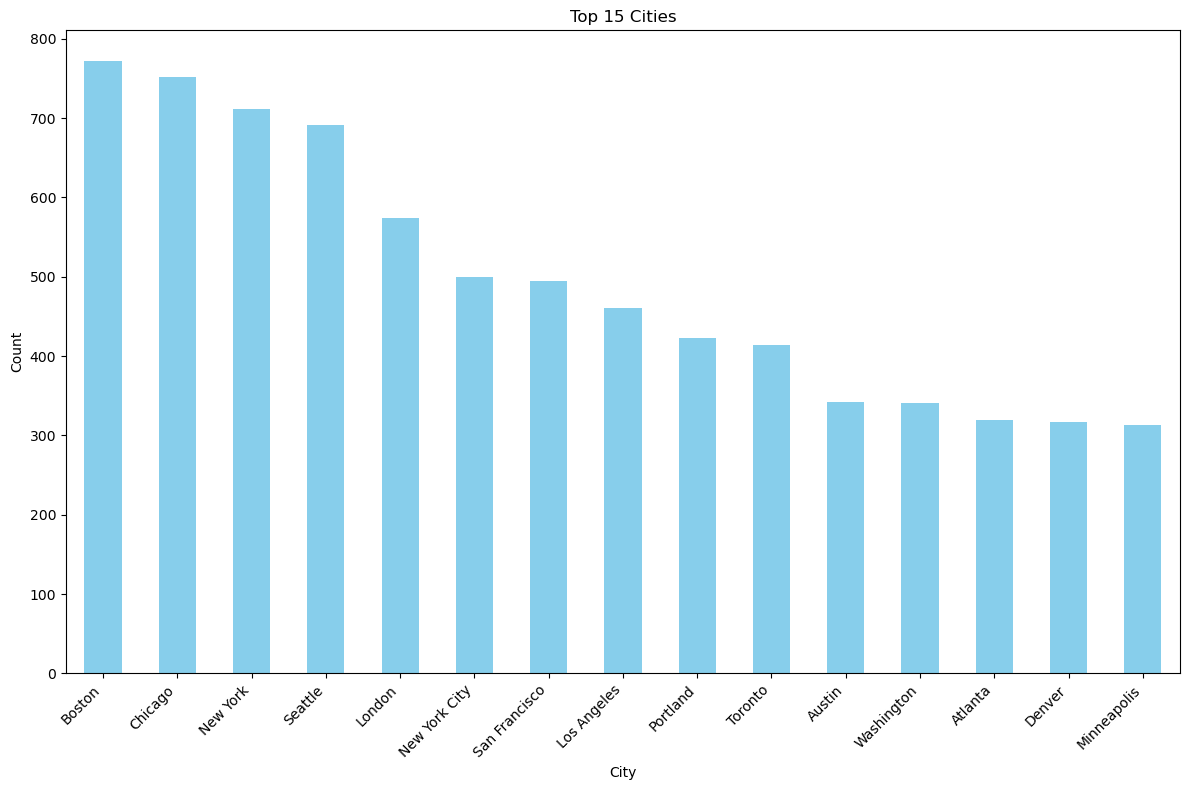

In [18]:
city_counts = df['city'].value_counts()

# Sort the counts in descending order and select top 15 instances
top_city= city_counts.head(15)

# Create a bar chart
plt.figure(figsize=(12, 8))
top_city.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 15 Cities')

# Show plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Out of the top 15 cities, 14 of them are in the United States, meaning realistically, the country that should be the majority should be the United States, which will be put to the test once we clean the "country" column.

#### Race

Since someone can be of multiple races, the sum of each value will exceed the total number of rows.

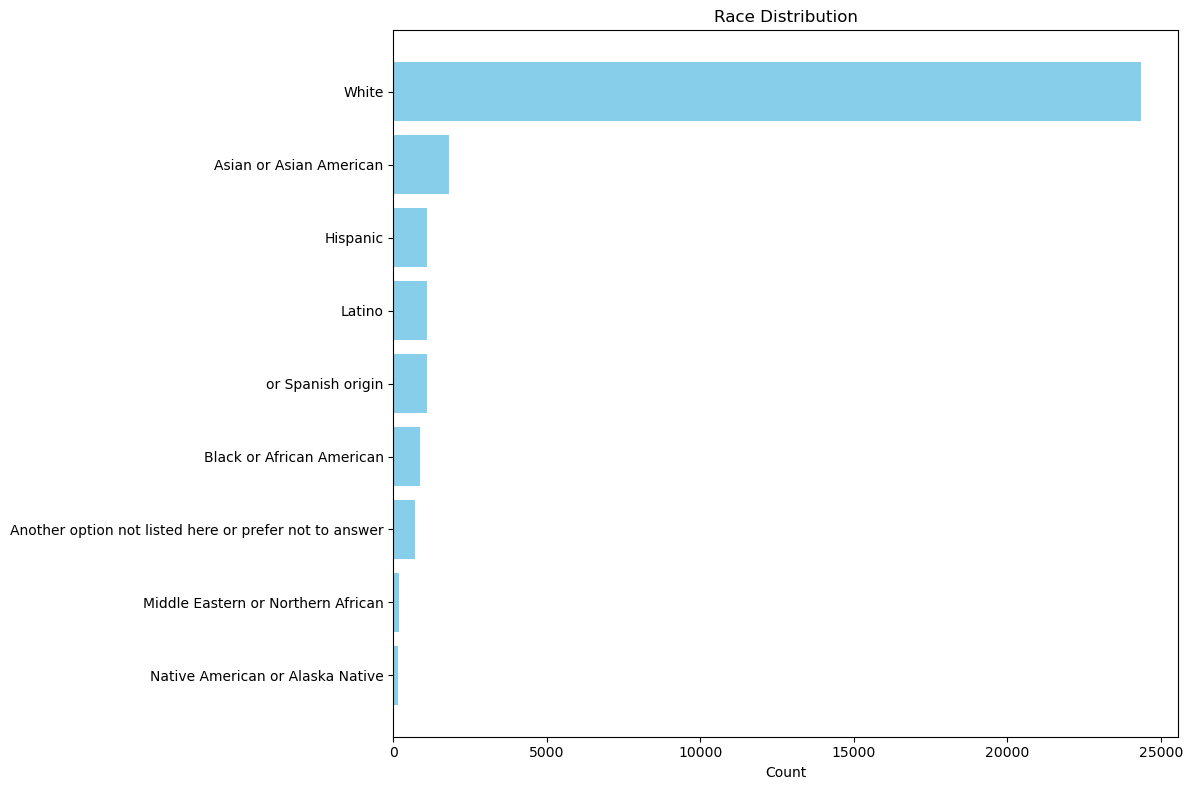

In [19]:
races = df['race'].str.get_dummies(sep=', ')
race_counts = races.sum(axis=0)

# Convert the counts to a DataFrame for plotting
race_counts_df = race_counts.to_frame(name='Count').reset_index()
race_counts_df.columns = ['Race', 'Count']

# Sort the DataFrame by count so the bar chart is ordered
race_counts_df = race_counts_df.sort_values('Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.barh(race_counts_df['Race'], race_counts_df['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Race Distribution')
plt.tight_layout() 
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()



#### Experience

Since we have two attributes in relation to experience Total Experience "total_exp" & Field Experience "field_exp", since they have the same values, for clarity reasons, they were both plotted on one graph.

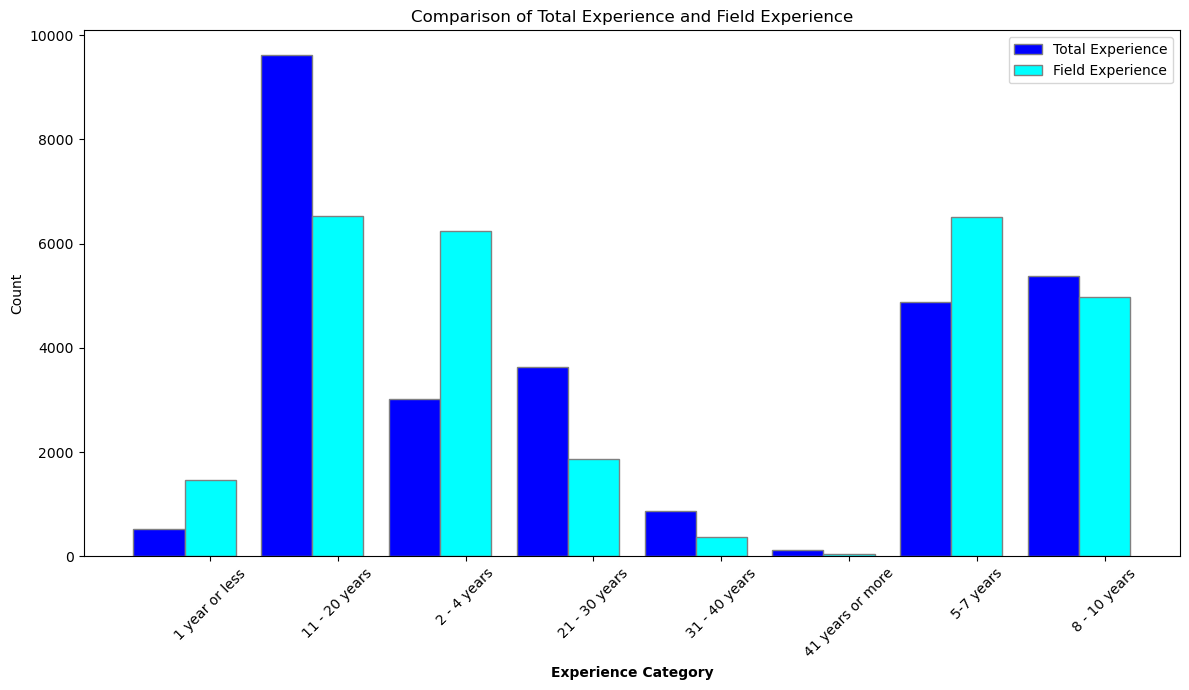

In [20]:

# Get the counts for each experience category
total_counts = df['total_exp'].value_counts().sort_index()
field_counts = df['field_exp'].value_counts().reindex(total_counts.index, fill_value=0)
barWidth = 0.4

# Set the positions of the bars on the x-axis
r1 = np.arange(len(total_counts))
r2 = [x + barWidth for x in r1]


# Create the bar chart
plt.figure(figsize=(12, 7))

# Create bars for total experience
plt.bar(r1, total_counts.values, color='blue', width=barWidth, edgecolor='grey', label='Total Experience')

# Create bars for field experience
plt.bar(r2, field_counts.values, color='cyan', width=barWidth, edgecolor='grey', label='Field Experience')

# Add labels to the chart
plt.xlabel('Experience Category', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(total_counts))], total_counts.index, rotation=45)
plt.ylabel('Count')
plt.title('Comparison of Total Experience and Field Experience')

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()

This aligns well with our visualization of the "age" attribute, as the lowest experience levels are those that correspond with the lowest and highest ages, demonstrated as a low proportion of survey respondents by the visualization of the age attribute

#### Educational Level

This attributes shows the highest level of education, since the values provided in the survey include all the education from High school onwards, we decided to fill the missing values with "Below Highschool"

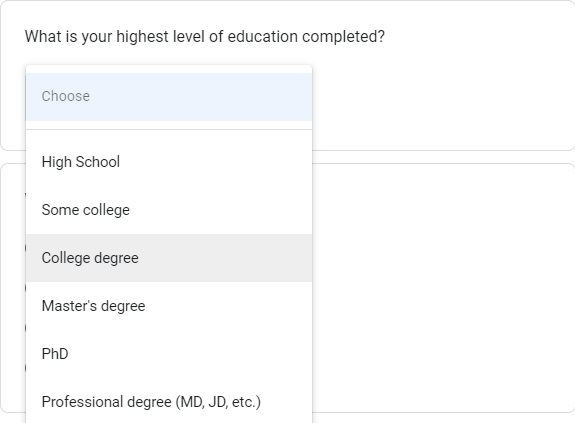

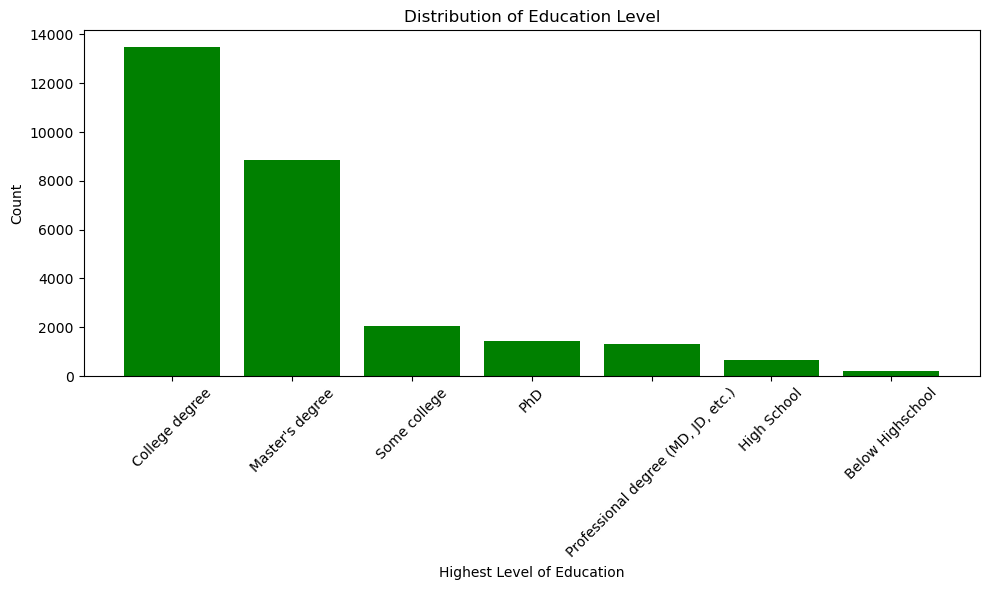

In [21]:
df['education_level'] = df['education_level'].fillna('Below Highschool')

# Count occurrences of each gender category
education_counts = df['education_level'].value_counts()

# Create a bar chart with different colors for each bar
plt.figure(figsize=(10, 6))
plt.bar(education_counts.index, education_counts.values, color=['green'])

# Adding labels and title
plt.xlabel('Highest Level of Education')
plt.ylabel('Count')
plt.title('Distribution of Education Level')

# Show plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This indicates that the majority of the people who participated in this survey have had college experience.

#### Gender

To make sure other rows arent removed, we made it so theres 3 values for gender, Man, Woman, Unknown

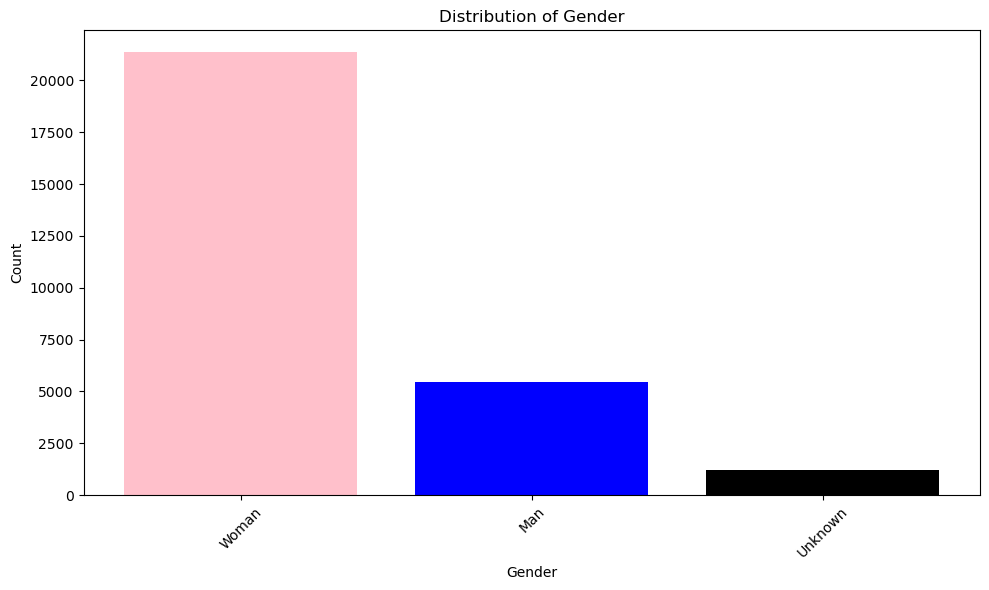

In [22]:
# Values to replace with 'Unknown'
values_to_replace = ['Prefer not to answer', 'Other or prefer not to answer','Non-binary', np.nan]

# Replace values with 'Unknown'
df['gender'] = df['gender'].replace(values_to_replace, 'Unknown')

# Count occurrences of each gender category
gender_counts = df['gender'].value_counts()

# Create a bar chart with different colors for each bar
plt.figure(figsize=(10, 6))
plt.bar(gender_counts.index, gender_counts.values, color=['pink', 'blue', 'black'])

# Adding labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')

# Show plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This indicates that there are almost 4x as many women as men who answered this survey

### Further Cleaning

Now we will remove the rows which have more than 25% missing values, but we need to take into consideration the columns that are considered additional information, like state (In this survey, they are US states, so every other country would have null values), add_compensation (Not everyone has bonuses), and other_currency (could have used the original currency options), so after excluding them we are left with 12 attributes, so we remove the rows which have more 3 or more missing values.

In [23]:
columns_to_exclude = ['state', 'add_compensation', 'other_currency']

# Calculate the percentage of missing values in each row, excluding specific columns
missing_percentage = df.drop(columns=columns_to_exclude).isna().mean(axis=1) * 100

# Sort missing percentage values in descending order and reset the index
missing_percentage_sorted = missing_percentage.sort_values(ascending=False).reset_index(drop=True)

# the threshold for missing percentage
threshold = 25

# Get the number of rows before filtering
rows_before = len(df)

# Filter out rows with missing percentage greater than or equal to the threshold
df = df[missing_percentage_sorted < threshold]

# Get the number of rows after filtering
rows_after = len(df)

# Calculate the number of rows deleted
rows_deleted = rows_before - rows_after

print(f"Number of rows deleted: {rows_deleted}")


Number of rows deleted: 0


#### Currency

Here, we want to clean the currency attribute, since we have two columns related to currency, "currency" & "other_currency", we decide to merge them, where the value of the prior is "other" it takes the value of the "other_currency", then we clean all the formats to one form.

In [24]:
# Merging them as discussed earlier (creating a new attribute from 2 other attributes)
df['merged_currency'] = df.apply(lambda row: row['other_currency'] if row['currency'] == 'Other' else row['currency'], axis=1) 

df['merged_currency'] = df['merged_currency'].str.strip().str.lower()

# Making sure all spellings are consistent
currency_misspellings = {
    'USD': ['us dollar', 'american dollars'],
    'CAD': ['canadian dollar'],
    'GBP': ['british pound'],
    'EUR': ['euro'],
    'AUD': ['aud australian', 'australian dollars', 'aud','aud/nzd'],
    'INR': ['indian rupees', 'inr (indian rupee)', 'rupees'],
    'CHF': ['swiss franc'],
    'MYR': ['malaysian ringgit'],
    'ZAR': ['south african rand'],
    'SEK': ['swedish krona'],
    'HKD': ['hong kong dollar'],
    'NOK': ['norwegian kroner (nok)', 'nok'],
    'DKK': ['dkk', 'danish kroner'],
    'BR$': ['brl (r$)', 'brl', 'brazilian real'],
    'CZK': ['czech koruna', 'czech crowns'],
    'PHP': ['philippine peso', 'philippine pesos', 'philippine peso (php)', 'php (philippine peso)'],
    'PLN': ['pln (polish zloty)', 'polish złoty', 'pln (zwoty)'],
    'TRY': ['turkish lira'],
    'CNY': ['chinese yuan', 'rmb (chinese yuan)', 'china rmb'],
    'ILS/NIS': ['ils (shekel)', 'israeli shekels', 'ils', 'nis (new israeli shekel)'],
    'JPY': ['japanese yen'],
    'TWD': ['ntd', 'taiwanese dollars'],
    'KRW': ['krw (korean won)', 'korean won'],
    'THB': ['thai baht', 'thai  baht'],
    'IDR': ['indonesian rupiah'],
    'NZD': ['new zealand dollar'],
    'ARS': ['argentinian peso (ars)', 'argentine peso', 'peso argentino'],
    'MXN': ['mexican pesos'],
    'SAR': ['saudi riyal'],
    'NGN': ['nigerian naira'],
    'COP': ['colombian peso'],
    'SGD': ['singapore dollar', 'singapore dollara'],
    'HRK': ['croatian kuna']
}


# Iterate through the dictionary and replace misspelled/alternate representations with standardized representations
for currency, misspellings in currency_misspellings.items():
    df['merged_currency'] = df['merged_currency'].replace(misspellings, currency)
nan_currency_rows = df[df['merged_currency'].isna()]


country_currency_map = {
    'United States': 'USD',
    'Malaysia': 'MYR',
    'USA ': 'USD', 
    'India': 'INR'
}

# Replace NaN values in the currency column with the corresponding currency based on country
for index, row in df.iterrows():
    if pd.isna(row['merged_currency']):
        country = row['country']
        if country in country_currency_map:
            df.at[index, 'merged_currency'] = country_currency_map[country]

            
df['merged_currency'] = df['merged_currency'].str.upper()

print("Unique merged_currency values:", df['merged_currency'].unique())


Unique merged_currency values: ['USD' 'GBP' 'CAD' 'EUR' 'AUD' 'INR' 'ARS' 'CHF' 'MYR' 'ZAR' 'SEK' 'HKD'
 'NOK' 'BR$' 'DKK' 'TTD' 'MXN' 'CZK' 'BDT' 'PHP' 'PLN' 'TRY' 'CNY'
 'ILS/NIS' 'JPY' 'TWD' 'SGD' 'KRW' 'THB' 'IDR' 'NZD' 'LKR' 'SAR' 'RM'
 'HRK' 'NGN' 'COP']


Cleaning Add_compensation, if its left null, we can safely assume they didnt receive an additional compensation, thus setting it to 0.

In [25]:
df['add_compensation'] = df['add_compensation'].fillna(0)

We convert all the incomes to one currency (USD for this implementation), to do so, you need to find the exchange rates of all currencies in relation to the currency of your choice (USD Here).

In [26]:
# Converting all the currencies to USD using these conversion rates obtained from google!
exchange_rates = {
    'USD': 1.0,
    'CAD': 0.746269,
    'GBP': 1.265823,
    'EUR': 1.086957,
    'AUD': 0.653595,
    'INR': 0.012048,
    'CHF': 1.149425,
    'MYR': 0.210084,
    'ZAR': 0.052301,
    'SEK': 0.095602,
    'HKD': 0.127877,
    'NOK': 0.094805,
    'BR$': 0.201898,
    'DKK': 0.144718,
    'TTD': 0.147514,
    'MXN': 0.058524,
    'CZK': 0.042724,
    'Bdt': 0.009122,
    'PHP': 0.017846,
    'PLN': 0.249314,
    'TRY': 0.032605,
    'CNY': 0.140449,
    'ILS/NIS': 0.272480,
    'JPY': 0.006697,
    'TWD': 0.031867,
    'SGD': 0.742942,
    'KRW': 0.000751,
    'THB': 0.027878,
    'IDR': 6.4075e-05,
    'NZD': 0.617284,
    'LKR': 0.003195,
    'ARS': 0.001205,
    'SAR': 0.266667,
    'RM': 0.209864,
    'HRK': 0.142430,
    'NGN': 0.000678,
    'COP': 0.000254
}

We define a method to clean our salary values.

In [27]:
# Cleaning the Salary from any symbols
def clean_salary(salary_value):
    if isinstance(salary_value, str):  # Check if it's a string
        for char in ['$', ',', 'k']: 
            salary_value = salary_value.replace(char, '') 
    return float(salary_value)  # Convert (string or float) to numeric form 

We decide to perform feature engineering by combining salary with additional compensation, forming a new feature, total income, which we will convert to usd!

In [28]:
#cleaning both columns
df['annual_salary'] = df['annual_salary'].apply(clean_salary) 
df['add_compensation'] = df['add_compensation'].apply(clean_salary) 

# Creating a new attribute from 3 attributes
df['total_income_usd'] = (df['annual_salary'] + df['add_compensation']) * df['merged_currency'].map(exchange_rates)

# Dropping the attributes we dont need anymore (Since Total_income_usd encompasses them all)
columns_to_drop = ['currency', 'other_currency','annual_salary', 'add_compensation','merged_currency'] 
df.drop(columns=columns_to_drop, inplace=True)

### Handling Outliers

In order for us to have a reliable model, we have to filter out the outliers, this was done using statistics formulas, learned in class.

In [29]:
Q1 = df['total_income_usd'].quantile(0.25)
Q3 = df['total_income_usd'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['total_income_usd'] >= lower_bound) & (df['total_income_usd'] <= upper_bound)]

### Converting to Classification by Domain Knowledge Binning

Since this is a classfication model, aiming to classify people into salary groups, we can not have the class label be numeric, so we use Feature Binning here, realizing both types of binning, after testing, we found out that Domain Knowledge Binning yields better results.

In [31]:
# Assuming 'df' is your DataFrame and 'column_name' is the column you want to analyze
column_data = df['total_income_usd']

# Calculate the range of data

data_range = column_data.max() - column_data.min()
print("Range of data:", data_range)

# Define bin width
bin_width = data_range / 3

# Create bins
bins = [column_data.min(), column_data.min() + bin_width, column_data.min() + 2*bin_width, column_data.max()]
print("Bins:", bins)

Range of data: 201000.0
Bins: [0.0, 67000.0, 134000.0, 201000.0]


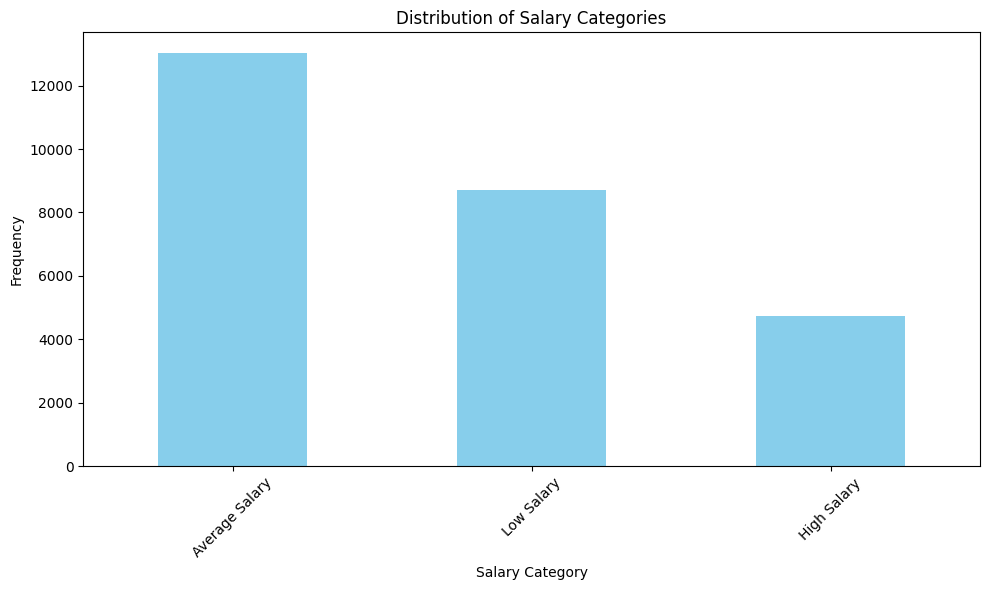

In [ ]:
# Define bins and labels
bins = [0, 60000, 120000, float('inf')]  # float('inf') = upper bound
labels = ['Low Salary', 'Average Salary', 'High Salary']

# Convert numerical salary to categorical
df['salary_category'] = pd.cut(df['total_income_usd'], bins=bins, labels=labels, right=False) # we dont include the right side

# Extract the 'salary_category' column
salary_categories = df['salary_category']

# Count occurrences of each category
category_counts = salary_categories.value_counts()

# Visualization Salary groups
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Salary Categories')
plt.xlabel('Salary Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotatin x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This aligns with real-world expectations, where the group of people who earn higher incomes are few compared to the rest.

Now we drop the numerical class label column

In [ ]:
df.drop(columns='total_income_usd', inplace=True) #dropping the numerical salary, this would only be used for regression

In [ ]:
df.head()

,age,industry,job_title,country,state,city,total_exp,field_exp,education_level,gender,race,first_state,salary_category
0,25-34,Education (Higher Education),Research and Instruction Librarian,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White,Massachusetts,Low Salary
1,25-34,Computing or Tech,Change & Internal Communications Manager,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Unknown,White,No State,Average Salary
2,25-34,"Accounting, Banking & Finance",Marketing Specialist,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White,Tennessee,Low Salary
3,25-34,Nonprofits,Program Manager,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White,Wisconsin,Average Salary
4,25-34,"Accounting, Banking & Finance",Accounting Manager,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White,South Carolina,Average Salary


### Cleaning Age

Here we aim to convert everything to numerical form, to be able to put it in all models (some models dont accept strings), since we used labelEncoding last time, we realized that it sets the values according to the order they appear in, but doesnt capture the ordinal essence, hence, we will define a dictionary with our values!

In [ ]:
# Define the ordinal valuation
ordinal_valuation = {
    'under 18': 0,
    '18-24': 1,
    '25-34': 2,
    '35-44': 3,
    '45-54': 4,
    '55-64': 5,
    '65 or over': 6,
}
# Label encoding may have given these different values as in the order they appear

# Mapping the values according to the numerical mapping
df['age'] = df['age'].map(ordinal_valuation)

### Cleaning Job Title & Industry

In [ ]:
# Print the amount of unique job titles
unique_job_titles = df['job_title'].nunique()
print("Number of unique job titles:", unique_job_titles)

# Print the amount of unique industries
unique_industries = df['industry'].nunique()
print("Number of unique industries:", unique_industries)

# Print the total number of rows in the DataFrame
total_rows = len(df)
print("Total number of rows:", total_rows)


Number of unique job titles: 13750
Number of unique industries: 1186
Total number of rows: 26467


Here we can tell that more than half the dataset has unique values for job_title, however unique only has 1217 unique values, so you may wonder why we chose BERT, since those unique values may be misspellings of the same word/phrase, not to mention other namings, and one hot encoding would add 1217 new columns, while BERT would add 768 new columns, making it better fit for this task.

**How does BERT function?**

Tokenization - The Initial Step:
Irrespective of the approach chosen to convert words into numerical representations, a fundamental step remains constant: reducing every piece of text to its smallest form, known as a token. Tokens can be individual words or segments of words.

Assigning Meaning to Tokens:
Once the text has been tokenized, BERT establishes a vocabulary. For instance, a standard version of BERT comprises a vocabulary of 30,522 words and over 50,000 tokens. At this juncture, one might wonder why not assign a unique random number to each token and conclude the process? The reason being, the same word may convey different meanings in different contexts.

Representing Tokens as Vectors:
Given the multitude of factors to be considered for each token, simply assigning a single numerical value to each token is insufficient. Instead, BERT assigns each token a vector, a list of numbers, to capture the diverse aspects associated with it. This transformation is accomplished through neural networks, which adjust their weights to map tokens to vector representations.




![BERT Architecture](https://miro.medium.com/v2/resize:fit:720/format:webp/1*FsjOkjHQNqyInJNzkvCQew.png)




**Then it maps them as vectors, using Neural Networks and adjusting its weights:**


![Mapping as vectors](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Qp9dvj31Vn8Psg3_cqs5eQ.png)

Initilization and Setup of BERT

In [ ]:
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip
Using device: cuda


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Data preprocessing

In [ ]:
df.loc[:, 'job_title'] = df.loc[:, 'job_title'].fillna('No Job Title')
df.loc[:, 'industry'] = df.loc[:, 'industry'].fillna('No Industry')


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocesses the given text by lowering, removing non-alphanumeric characters,
    lemmatizing, and removing stopwords."""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')]
    return ' '.join(words)

def get_bert_embeddings(text):
    """Generates BERT embeddings for the given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embeddings

# Preprocess the 'job_title' and 'industry' columns
start_time = time.time()
def process_and_embed(df):
    df_copy = df.copy()  # Work with a copy to avoid setting on a slice
    df_copy['job_title_processed'] = df_copy['job_title'].apply(preprocess_text)
    df_copy['industry_processed'] = df_copy['industry'].apply(preprocess_text)
    
    embeddings_job_title = np.vstack(df_copy['job_title_processed'].apply(get_bert_embeddings))
    embeddings_industry = np.vstack(df_copy['industry_processed'].apply(get_bert_embeddings))
    
    embeddings_job_title_df = pd.DataFrame(embeddings_job_title)
    embeddings_industry_df = pd.DataFrame(embeddings_industry)
    
    return pd.concat([df_copy, embeddings_job_title_df, embeddings_industry_df], axis=1)

# Call the function and assign the result to df to update it
df = process_and_embed(df)
end_time = time.time()

In [ ]:
df

,age,industry,job_title,country,state,city,total_exp,field_exp,education_level,gender,...,758,759,760,761,762,763,764,765,766,767
0,2.0,Education (Higher Education),Research and Instruction Librarian,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,...,-0.045590,-0.287708,0.290331,-0.079835,-0.068132,-0.218815,0.119519,-0.413497,0.084915,-0.020428
1,2.0,Computing or Tech,Change & Internal Communications Manager,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Unknown,...,0.433221,-0.059964,0.190883,-0.014104,0.018001,-0.277823,-0.061721,0.103584,-0.010680,-0.123777
2,2.0,"Accounting, Banking & Finance",Marketing Specialist,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,...,0.460388,-0.251983,0.141880,-0.085827,0.143669,-0.562029,-0.323043,-0.364457,-0.217717,-0.167628
3,2.0,Nonprofits,Program Manager,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,...,0.524591,-0.142209,0.055138,-0.226899,0.048632,-0.555246,0.077519,-0.009071,-0.228666,-0.294527
4,2.0,"Accounting, Banking & Finance",Accounting Manager,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,...,0.460388,-0.251983,0.141880,-0.085827,0.143669,-0.562029,-0.323043,-0.364457,-0.217717,-0.167628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.328462,-0.002434,0.082097,-0.174432,0.034094,-0.448150,-0.239960,-0.074809,0.251482,0.050915
26420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.433221,-0.059964,0.190883,-0.014104,0.018001,-0.277823,-0.061721,0.103584,-0.010680,-0.123777
26421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.433221,-0.059964,0.190883,-0.014104,0.018001,-0.277823,-0.061721,0.103584,-0.010680,-0.123777
26436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.460388,-0.251983,0.141880,-0.085827,0.143669,-0.562029,-0.323043,-0.364457,-0.217717,-0.167628


Handling Categorical Variables

In [ ]:
# # Handling categorical variables with low frequency
# threshold = 5  # Adjust threshold based on your needs
# for column in ['job_title', 'industry']:  # Add or remove columns as needed
#     counts = df[column].value_counts()
#     rare_categories = counts[counts < threshold].index
#     df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)

# # One-hot encoding for categorical columns
# encoder = OneHotEncoder(handle_unknown='ignore')
# encoded_features = encoder.fit_transform(df[['job_title', 'industry']]).toarray()
# encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# # Drop columns no longer needed
# df.drop(['job_title', 'industry', 'job_title_processed', 'industry_processed'], axis=1, inplace=True)

# # Concatenate one-hot encoded columns with the original DataFrame
# df = pd.concat([df, encoded_features_df], axis=1)
# df.reset_index(drop=True, inplace=True)


Execution Time

In [ ]:
# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 528.4809215068817 seconds


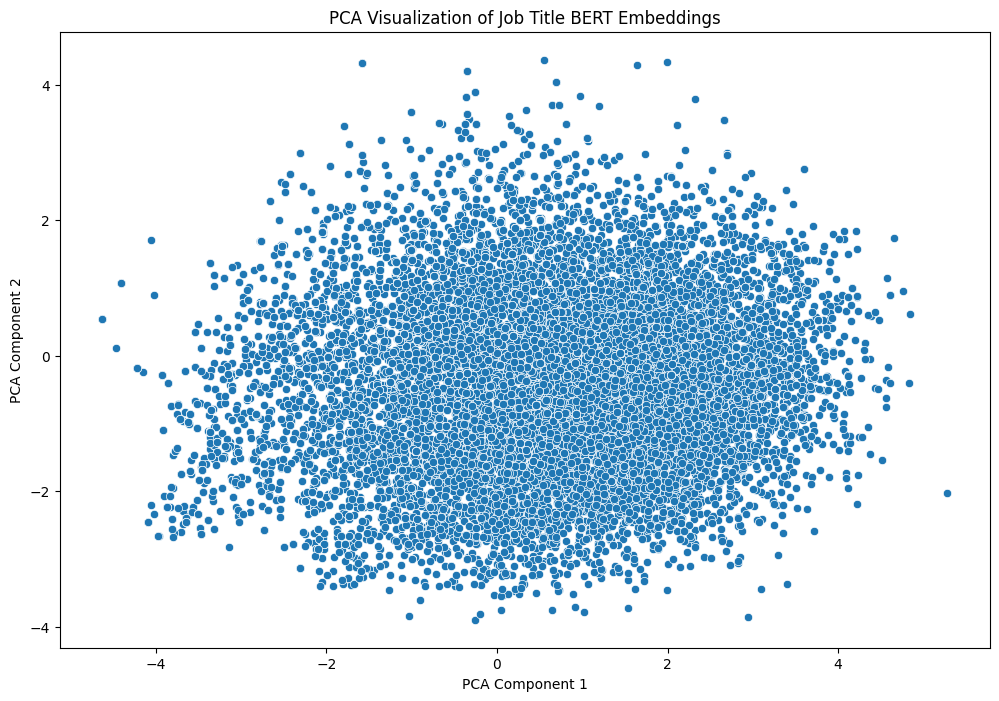

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
job_title_pca = pca.fit_transform(embeddings_job_title_df)

# Convert to DataFrame
job_title_pca_df = pd.DataFrame(job_title_pca, columns=['PCA1', 'PCA2'])

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', data=job_title_pca_df)

# Adding labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Job Title BERT Embeddings')

# Show plot
plt.show()


### Cleaning Country

Since there are so many unique values for country, cleaning it will be difficult, first we replace all the countries with a state to USA, next we replace all the countries found in the datasat and the ethinicity into the country, for example Italy/Italian -> Italy

In [ ]:
df.loc[(~df['state'].isnull()) & (df['state'] != ''), 'country'] = 'United States of America'

In [ ]:
country_patterns = {
    r"\bcanad(a|ian)\b": "Canada",
    r"\bswitzerland\b|\bswiss\b": "Switzerland",
    r"\bfrance\b|\bfrench\b": "France",
    r"\baustralia\b|\baustralian\b": "Australia",
    r"\bgermany\b|\bgerman\b": "Germany",
    r"\bireland\b|\birish\b": "Ireland",
    r"\bspain\b|\bspanish\b": "Spain",
    r"\bitaly\b|\bitalian\b": "Italy",
    r"\bsweden\b|\bswedish\b": "Sweden",
    r"\bfinland\b|\bfinnish\b": "Finland",
    r"\bindia\b|\bindian\b": "India",
    r"\bportugal\b|\bportuguese\b": "Portugal",
    r"\bnetherlands\b|\bdutch\b": "Netherlands",
    r"\bsouth africa\b": "South Africa",
    r"\bsaudi arabia\b|\bksa\b": "Saudi Arabia",
    r"\bnew zealand\b|\bnz\b": "New Zealand",
    r"\bsingapore\b": "Singapore",
    r"\bmexico\b": "Mexico",
    r"\bunited arab emirates\b|\buae\b": "United Arab Emirates",
    r"\bczech republic\b|\bczechia\b": "Czech Republic",
    r"\bcroatia\b": "Croatia",
    r"\bjapan\b": "Japan",
    r"\bnigeria\b": "Nigeria",
    r"\bdenmark\b": "Denmark",
    r"\bpakistan\b": "Pakistan",
    r"\bpoland\b": "Poland",
    r"\bchina\b": "China",
    r"\bsri lanka\b": "Sri Lanka",
    r"\bunited kingdom\b|\buk\b|\bengland\b|\bscotland\b|\bwales\b|\bbritain\b|\bnorthern ireland\b": "United Kingdom",
    r"\busa\b|\bunited states\b|\bamerica\b|\bUS\b": "United States of America"
    
}


In [ ]:
def standardize_countries(value):
    value_str = str(value)
    for pattern, country in country_patterns.items():
        if re.search(pattern, value_str, re.IGNORECASE):
            return country
    return value
df['country'] = df['country'].apply(lambda x: standardize_countries(x))
df['country'] = df['country'].str.strip()


In [ ]:
df['country'].unique()

array(['United States of America', 'United Kingdom', 'Canada',
       'Netherlands', 'Australia', 'Spain', 'Finland', 'France',
       'Ireland', 'India', 'Argentina', 'Denmark', 'Switzerland',
       'Bermuda', 'Germany', 'Malaysia', 'U.S.', 'Mexico', 'South Africa',
       'Belgium', 'Sweden', 'Hong Kong', 'Kuwait', 'Norway', 'Sri Lanka',
       'Greece', 'Japan', 'Austria', 'Brazil', 'Global', 'Canadw',
       'Hungary', 'Luxembourg', 'New Zealand', 'Trinidad and Tobago',
       'Cayman Islands', 'Can', 'Czech Republic', 'Latvia', 'Puerto Rico',
       'Rwanda', 'United Arab Emirates', 'U.K.', 'Romania',
       'United Kindom', 'Serbia', 'Philippines', 'Russia', 'Poland',
       'Turkey', 'Canda', 'Catalonia',
       '$2,175.84/year is deducted for benefits', 'Italy',
       'Jersey, Channel islands', 'China', 'Afghanistan', 'Israel',
       'Csnada', 'Taiwan', 'Canad', 'Cambodia', 'Vietnam', 'Remote',
       'Singapore', 'South Korea', 'Thailand', 'Bangladesh', 'Lithuania',
       

By looking at the unique values of the country column, we manually do the rest!

In [ ]:
# Create a dictionary mapping correct country names to their variations and misspellings
country_corrections = {
    'United States of America': 
            ['USA', 'United States', 'United States of America', 'United Stated', 'United Statesp',
            'United Stattes', 'United Statea', 'United States of American',
            'United States (I work from home and my clients are all over the US/Canada/PR',
            'Unted States','U.SA' ,'United Statesp', 'United States of Americas', 'United state', 'United  States',
            'United States is America', 'Uniter Statez', 'USA tomorrow', 'US govt employee overseas, country withheld',
            'USAA', 'United States- Puerto Rico', 'US of A', 'United Statss', '🇺🇸', 'isa', 'United Statws',
            'Unites States','United Statues', 'United statew', 'U. S. ', 'United Sates',
            'Uniited States', 'Worldwide (based in US but short term trips aroudn the world)',
            'United Sates of America', 'Uniyes States', 'us',
            'I am located in Canada but I work for a company in the US','Uniyed states', 'U.A.', 'United Stares', 'Unite States',
            'USA-- Virgin Islands', "I work for an US based company but I'm from Argentina.",'United states','U.S.' 'USA', 'U.S>','U. S',
            'San Francisco','California', 'ISA', 'U.S.A', 'U.S.A.', 'u.s.', 'U.S', 'U. S.', 'U.s.', 'U.s.a.', 'USS',
            'Uniteed States', 'I.S.', 'Unites states', 'UnitedStates', 'U.K', 'USAB', 'Unitied States', 'United Sttes',
            'united stated', 'Usat', 'Unitef Stated', 'UA', 'USaa', 'United y', 'USD',  'United State', 'United Statees',
            'United Status', 'Untied States', 'United Stateds', 'U.S.'],
    
    'Canada': ['Canada, Ottawa, ontario', 'Canadw', 'Can', 'Canda', 'Csnada', 'Canad', 'Canadá' ],
    'United Kingdom': ['Unites kingdom', 'Englang', 'London', 'Unites kingdom','U.K.', 'United Kindom', 'United Kingdomk'],
    'Netherlands': ['Nederland', 'NL', 'Holland'],
    'Australia': ['Australi'],
    'Denmark': ['Danmark'],
    'Luxembourg': ['Luxemburg'],
    'Hong Kong': ['hong konh'],
    'Mexico': ['México'],
    'Thailand': ['ARGENTINA BUT MY ORG IS IN THAILAND'],
    'Spain': ['Catalonia'],
    'Brazil': ['Brasil'],
    'Global': ['Remote', 'International', 'Remote (philippines)', 'n/a (remote from wherever I want)'],
    'Channel Islands': ['Jersey, Channel islands'],
    'Panama': ['panamá','Panamá'],
    'Ivory Coast': ["Cote d'Ivoire"],
    'Bahamas': ['the bahamas'],
    'No Country Listed': ['IS','UXZ','na','ss', 'No Country Listed', 'Y','$2,175.84/year is deducted for benefits',
                          'Policy', 'europe', 'Africa', '', 'Contracts', 
                          '''We don't get raises, we get quarterly bonuses, but they periodically asses 
                          income in the area you work, so I got a raise because a 3rd party assessment showed I was paid too little
                          for the area we were located''', np.nan,
                          'Currently finance', 'bonus based on meeting yearly goals set w/ my supervisor',
                          '''I earn commission on sales. If I meet quota, I'm guaranteed another 16k min. Last year i earned an additional 27k.
                          It's not uncommon for people in my space to earn 100k+ after commission.''',
                          'I was brought in on this salary to help with the EHR and very quickly was promoted to current position but compensation was not altered.']
}

# Replace misspellings with correct country names
for correct_country, variations in country_corrections.items():
    df['country'] = df['country'].replace(variations, correct_country)

df = df.reset_index(drop=True)  # Reset the index after replacements
unique_countries = df['country'].unique()
print(f"Unique countries:\n{unique_countries}")

Unique countries:
['United States of America' 'United Kingdom' 'Canada' 'Netherlands'
 'Australia' 'Spain' 'Finland' 'France' 'Ireland' 'India' 'Argentina'
 'Denmark' 'Switzerland' 'Bermuda' 'Germany' 'Malaysia' 'Mexico'
 'South Africa' 'Belgium' 'Sweden' 'Hong Kong' 'Kuwait' 'Norway'
 'Sri Lanka' 'Greece' 'Japan' 'Austria' 'Brazil' 'Global' 'Hungary'
 'Luxembourg' 'New Zealand' 'Trinidad and Tobago' 'Cayman Islands'
 'Czech Republic' 'Latvia' 'Puerto Rico' 'Rwanda' 'United Arab Emirates'
 'Romania' 'Serbia' 'Philippines' 'Russia' 'Poland' 'Turkey'
 'No Country Listed' 'Italy' 'Channel Islands' 'China' 'Afghanistan'
 'Israel' 'Taiwan' 'Cambodia' 'Vietnam' 'Singapore' 'South Korea'
 'Thailand' 'Bangladesh' 'Lithuania' 'Eritrea' 'Indonesia' 'Cuba'
 'Slovenia' 'Ivory Coast' 'Somalia' 'Slovakia' 'Portugal' 'Sierra Leone'
 'The Bahamas' 'Costa Rica' 'Chile' 'Qatar' 'Nigeria' 'Panama' 'Congo'
 'Uruguay' 'Pakistan' 'Uganda' 'Malta' 'Saudi Arabia' 'Bulgaria' 'Estonia'
 'Morocco' 'Ecuador' 'Zim

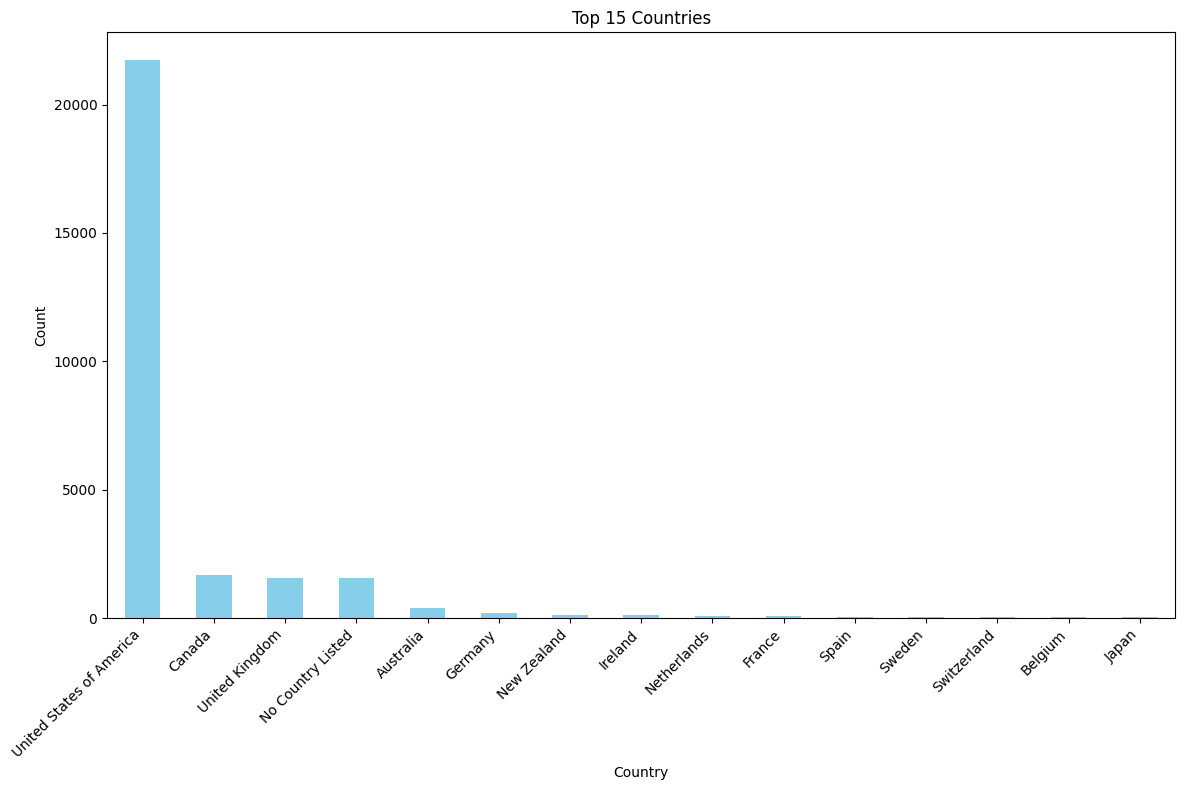

In [ ]:
country_counts = df['country'].value_counts()

# Sort the counts in descending order and select top 15 instances
top_countries= country_counts.head(15)

# Create a bar chart
plt.figure(figsize=(12, 8))
top_countries.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 15 Countries')

# Show plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This confirms and aligns with the City visualization above.

### Additional Attribute (GDP)

After testing with Countries being one hot encoded, we found out the accuracy was not high, so we decided on creating our own new attribute, GDP, which displays the countries GDP per Capita, To do this we found another dataset from kaggle, and after making sure our countries align with theirs (Consistency), we merged them! This boosted our accuracy by alot!

In [ ]:
gdp = pd.read_csv('/kaggle/input/mlproj/gdp.csv')

# Normalize the 'Country' column in both datasets to ensure a match
# This includes converting to lowercase and stripping any leading/trailing spaces
df['country'] = df['country'].str.lower().str.strip()
gdp['Country'] = gdp['Country'].str.lower().str.strip()

# Merge the datasets to associate GDP values with the countries in your first dataset
# This merge operation ensures each country in table1 is matched with its corresponding GDP from gdp.csv
df = pd.merge(df, gdp, left_on='country', right_on='Country', how='left')


# Remove tche extra 'country' column from the merge, if desired
df.drop('Country', axis=1, inplace=True)

# Check for any null values in the 'gdp' column to ensure all countries were matched
if df['gdp'].isnull().any():
    print("Warning: There are countries in table1 without a matching GDP in gdp.csv.")
else:
    print("All countries in table1 have been successfully matched with their GDP.")
    
df.drop('country', axis=1, inplace=True)
# country_array = df['country'].values.reshape(-1, 1)

The missing gdps are due to some countries being listed as global, to combat this, we will fit it with the global average gdp per capita, according to https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=1W&most_recent_value_desc=true this value is 12687

In [ ]:
df["gdp"] = df['gdp'].fillna(12687)


### State

In [ ]:
# Step 3: One-hot encode the 'first_state' column
first_state_one_hot = pd.get_dummies(df['first_state'], prefix='state')

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
df = pd.concat([df, first_state_one_hot], axis=1)

# Optionally, drop the 'state' and 'first_state' columns if they are no longer needed
df.drop(columns=['state', 'first_state'], inplace=True)

# Reset the index, if necessary
df.reset_index(drop=True, inplace=True)

### City

This code standardizes and maps city names to a consistent format, then encodes them numerically, facilitating analysis or modeling tasks requiring uniform city representations.

In [ ]:
# Load the list of cities from geonamescache
gc = geonamescache.GeonamesCache()
cities = [city['name'] for city in gc.get_cities().values()]
city_map = {city: re.sub(r'[^a-zA-Z\s]', '', city).strip() for city in cities}

# Clean and map the 'city' column using the city_map dictionary
def clean_and_map_city_name(city):
    city = city_map.get(city, 'other')
    city = re.sub(r'\b(?:city|area|capital)\b', '', city, flags=re.IGNORECASE).strip()
    return city

# Assuming df is your DataFrame
df['clean_city'] = df['city'].astype(str).apply(clean_and_map_city_name)

# Drop the original 'city' column
df.drop(['city'], axis=1, inplace=True)

label_encoder = LabelEncoder()
df['clean_city'] = label_encoder.fit_transform(df['clean_city'])
df.reset_index(drop=True, inplace=True)

### Total & Field Experience

It is common practice to convert all attributes to numerical values, as some models can only take in numerical values, Label Encoding was not used here to maintain the hierarchy of the values, and mapping them ordinally

In [ ]:
total_exp_map = {
    '1 year or less': 1,
    '2 - 4 years': 3,
    '5-7 years': 6,
    '8 - 10 years': 9,
    '11 - 20 years': 15,
    '21 - 30 years': 25,
    '31 - 40 years': 35,
    '41 years or more': 45
}

field_exp_map = total_exp_map.copy()  # Assuming same mapping as total_exp


df['total_exp_encoded'] = df['total_exp'].map(total_exp_map)
df['field_exp_encoded'] = df['field_exp'].map(field_exp_map)

df.drop(['total_exp','field_exp'], axis=1, inplace=True) # 

### Education Level

In [ ]:
education_level_map = {
    'Below Highschool': 1,
    'High School': 3,
    'Some college': 5,
    'College degree': 8,
    "Master's degree": 10,
    'PhD': 13,
    'Professional degree (MD, JD, etc.)':  15
} 

df['education_level'] = df['education_level'].map(education_level_map)

### Gender

Since you can only have 1 gender, and since theres only 3 different values for it, we decide to one hot encode it.

In [ ]:
# Reset the index here, immediately after filtering
df.reset_index(drop=True, inplace=True)

# Proceed with encoding
encoder = OneHotEncoder(handle_unknown='ignore') 
encoded_features = encoder.fit_transform(df[['gender']]).toarray()  # Convert to array

# Now, when you concatenate, the indices will match, and you won't get nulls unexpectedly.
df = pd.concat([df, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())], axis=1)

# Drop the original 'gender' column as before
df.drop('gender', axis=1, inplace=True)


### Race

Since there can be more than one race for each person, we use multilabelbinarizer to maintain this.

In [ ]:
df['race'].unique()

array(['White', 'Hispanic, Latino, or Spanish origin, White',
       'Asian or Asian American, White', 'Asian or Asian American',
       'Another option not listed here or prefer not to answer',
       'Hispanic, Latino, or Spanish origin',
       'Middle Eastern or Northern African',
       'Hispanic, Latino, or Spanish origin, Middle Eastern or Northern African, White',
       'Black or African American', 'Black or African American, White',
       nan,
       'Black or African American, Hispanic, Latino, or Spanish origin, White',
       'Native American or Alaska Native',
       'Native American or Alaska Native, White',
       'Hispanic, Latino, or Spanish origin, Another option not listed here or prefer not to answer',
       'Black or African American, Middle Eastern or Northern African, Native American or Alaska Native, White',
       'White, Another option not listed here or prefer not to answer',
       'Black or African American, Native American or Alaska Native, White',
    

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
df['race'] = df['race'].fillna("Another option not listed here or prefer not to answer")

# Split the 'race' column by comma and convert it into a list of labels
race_labels = df['race'].str.split(', ')

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform the list of labels into binary encoded columns
race_encoded = pd.DataFrame(mlb.fit_transform(race_labels), columns=mlb.classes_, index=df.index)

# Concatenate the binary encoded columns with the original DataFrame
df = pd.concat([df.drop(columns=['race']), race_encoded], axis=1)

In [ ]:
df.reset_index(drop=True, inplace=True)

### Heatmap

A heatmap is a graphical representation where the values of a matrix are depicted using colors. In this exercise, a heatmap is employed to visualize the relation and importance of each attribute with each other, but more importantly, the class label. Each row represents an attribute, while columns represent the the attributes in relation with it, and colors indicating the degree of importance (e.g., warmer colors for higher importance). By examining the heatmap, we can discern which attributes are more influential in determining the class label.

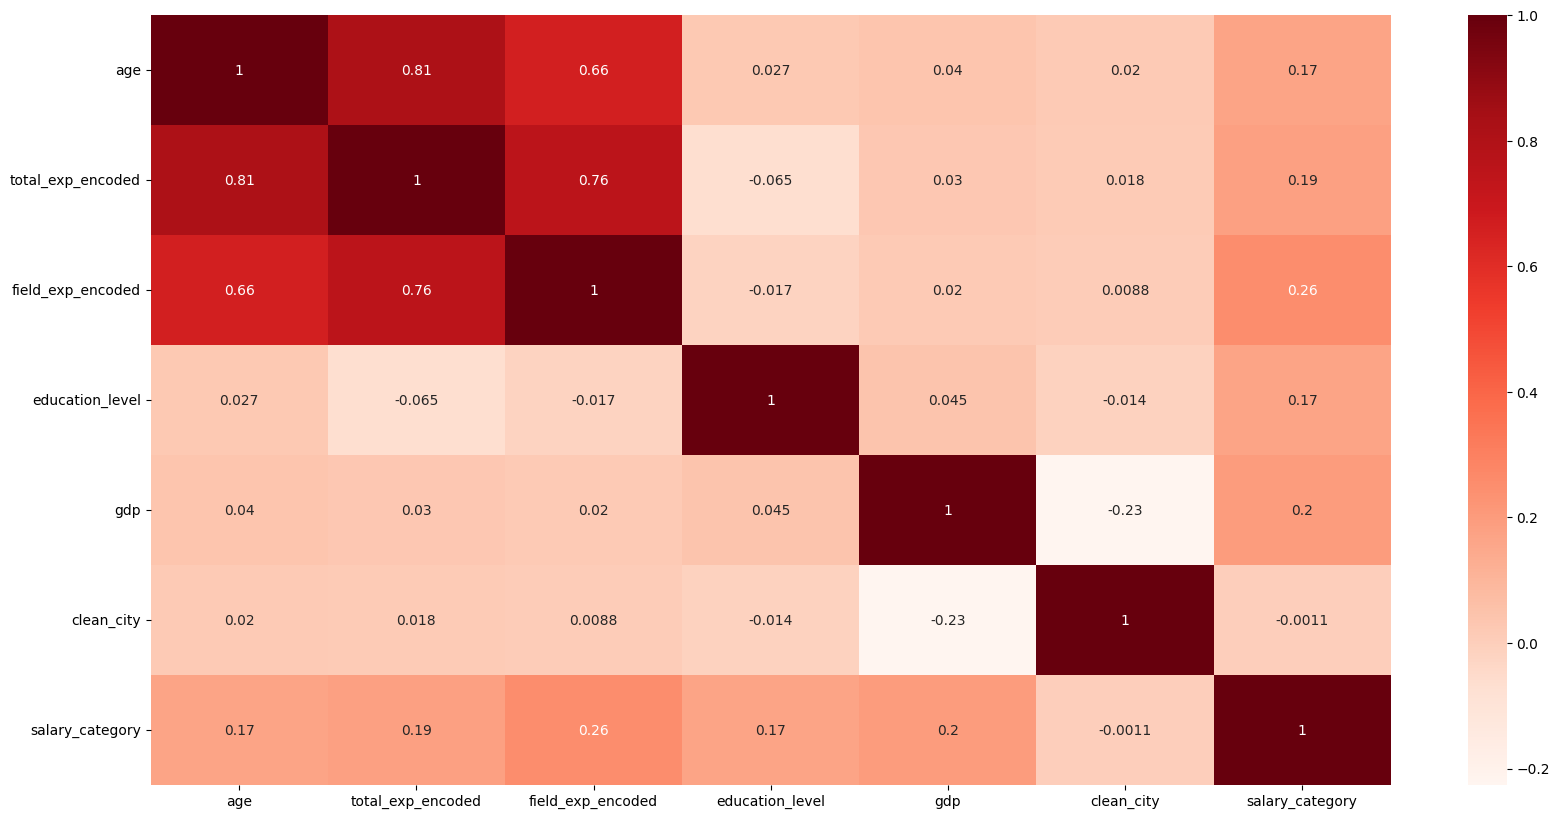

Relevant Features: salary_category      1.000000
field_exp_encoded    0.255536
gdp                  0.197069
total_exp_encoded    0.185103
education_level      0.171066
age                  0.169755
Name: salary_category, dtype: float64


In [ ]:
# Map 'salary_category' to numeric values
salary_mapping = {'Low Salary': 0, 'Average Salary': 1, 'High Salary': 2}
df['salary_category'] = df['salary_category'].map(salary_mapping)

columns_for_correlation = [
    'age', 'total_exp_encoded', 'field_exp_encoded', 'education_level', 
     'gdp','clean_city', 'salary_category', 
]

# Create a new DataFrame with selected columns
df_selected_for_correlation = df[columns_for_correlation]

# Now calculate correlations on this selected DataFrame
cor = df_selected_for_correlation.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Correlation with the 'salary_category' variable
cor_target = abs(cor['salary_category']).sort_values(ascending=False)

# Selecting highly correlated features (adjust threshold as needed)
relevant_features = cor_target[cor_target > 0.01]
irrelevant_features = cor_target[cor_target <= 0.01]

print("Relevant Features:", relevant_features)

Here we can tell that clean city has a negative correlation with Salary, so we drop it for better accuracy

In [ ]:
df.drop(columns=['clean_city'], inplace=True)

In [ ]:
# Count the number of missing values in each column
na_counts = df.isna().sum()

print("Number of missing values in each column:")
print(na_counts)

Number of missing values in each column:
age                                   1539
education_level                       1539
salary_category                       1539
0                                     1539
1                                     1539
                                      ... 
Latino                                   0
Middle Eastern or Northern African       0
Native American or Alaska Native         0
White                                    0
or Spanish origin                        0
Length: 2368, dtype: int64


In [ ]:
# Get the initial number of rows
initial_rows = df.shape[0]

# Drop rows with NaN values
df = df.dropna()
df.reset_index(drop=True, inplace=True)

# Calculate the number of rows dropped
rows_dropped = initial_rows - df.shape[0]

print(f"Dropped {rows_dropped} rows.")

Dropped 3008 rows.


### Model Building and Results

Our selected model of choice will be 

In [ ]:
sampled_dfs = []  # List to hold the sampled DataFrames
labels=[0,1,2]
for label in labels:
    sampled = df[df['salary_category'] == label].sample(n=1000, random_state=42)
    sampled_dfs.append(sampled)

# Concatenate all the sampled DataFrames
sampled_df = pd.concat(sampled_dfs).reset_index(drop=True)


### Model Training

In [ ]:
sampled_dfs = [] 
labels=[0,1,2]
for label in labels:
    sampled = df[df['salary_category'] == label].sample(n=2000, random_state=42)
    sampled_dfs.append(sampled)
# Concatenate all the sampled DataFrames
sampled_df = pd.concat(sampled_dfs).reset_index(drop=True)

In [ ]:
# Function to sanitize column names
def sanitize_column_names(columns):
    sanitized_columns = []
    for column in columns:
        column_str = str(column)  # Convert column to string
        sanitized_column = re.sub(r'\W+', '_', column_str)  # Replace non-alphanumeric characters with underscores
        sanitized_columns.append(sanitized_column)
    return sanitized_columns

# Sanitize column names
sampled_df.columns = sanitize_column_names(sampled_df.columns)
sampled_test.columns = sanitize_column_names(sampled_test.columns)
# Assuming 'y' is your target variable Series

# Function to generate unique column names
def generate_unique_names(df):
    new_column_names = []
    seen_names = set()
    for column_name in df.columns:
        new_column_name = column_name
        count = 1
        while new_column_name in seen_names:
            new_column_name = f"{column_name}_{count}"
            count += 1
        new_column_names.append(new_column_name)
        seen_names.add(new_column_name)
    return new_column_names

# Rename columns in the DataFrame
sampled_df.columns = generate_unique_names(sampled_df)
sampled_test.columns = generate_unique_names(sampled_test)

Graph-based datasets are collections of data where the instances are represented as nodes in a graph, and the relationships between these instances are represented as edges. This form of data representation captures the interconnectivity and the complex relationships between data points, which are not typically represented in traditional tabular datasets.

A Graph Neural Network (GNN) is a type of neural network that operates on graph structures. GNNs have gained popularity because they can exploit the rich relational information between nodes in a graph, which can lead to better performance for certain tasks compared to models that ignore these relationships.

The use of GNNs is particularly effective in scenarios where the relationships between instances are as important as the instances themselves. For example, in social networks, the structure and the connections between users can be highly informative for tasks like recommendation systems or community detection.

GNNs can potentially yield higher accuracy than models trained on normal datasets because they can assess not only the attributes of the individual instances but also the relations between instances. This is achieved through a process known as message passing, where nodes aggregate information from their neighbors, effectively allowing the nodes to 'communicate' with each other. By iteratively updating each node's information, GNNs can learn to capture the structural information of the entire graph.

In traditional models, the primary focus is on the relationship between attributes of an instance and the target label. These models often assume that instances are independent and identically distributed, which isn't the case in graph data where nodes can be interconnected.

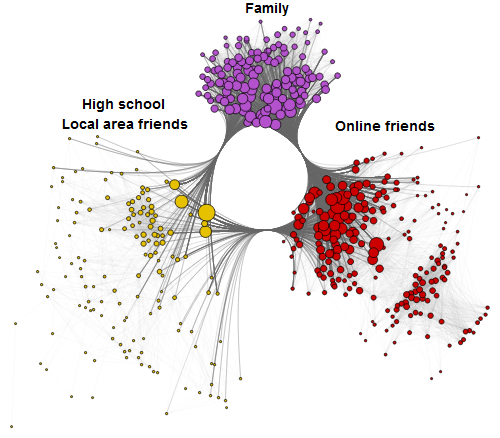

Setup and Preliminaries

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Dynamically extract features
features = sampled_df.columns.drop('salary_category')


Graph Creation

In [ ]:
G = nx.Graph()
for index, row in sampled_df.iterrows():
    node_attributes = {str(key): value for key, value in row[features].to_dict().items()}
    G.add_node(index, **node_attributes)

# Assuming a fully connected graph for demonstration purposes
for i in G.nodes:
    for j in G.nodes:
        if i != j:
            G.add_edge(i, j)


Data Preparation for GNN

In [ ]:
# Scaling features and preparing edge index
scaler = StandardScaler()
X = scaler.fit_transform(sampled_df[features])
y = sampled_df['salary_category'].to_numpy()

edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Creating PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

Data Splitting

In [ ]:
# Splitting data into train and test sets
train_indices, test_indices = train_test_split(range(data.num_nodes), test_size=0.2)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask[test_indices] = True


Model Definition

In [ ]:
# Define a GCN Model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 3)  # Assuming 3 salary groups

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Instantiate model, define loss function and optimizer
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

Training and Evaluation Functions

In [ ]:
loss_values = []
accuracy_values = []

def train_and_evaluate(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    
    return loss.item(), acc

# Test the model
def test():
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc


Training Loop

In [ ]:
# Run the training loop and collect loss and accuracy
for epoch in range(1, 201):
    loss, acc = train_and_evaluate(model, data, optimizer, criterion)
    loss_values.append(loss)
    accuracy_values.append(acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}, Accuracy: {acc}')


Epoch 10, Loss: 1.2682942152023315, Accuracy: 0.39166666666666666
Epoch 20, Loss: 0.71804279088974, Accuracy: 0.62
Epoch 30, Loss: 0.5481690764427185, Accuracy: 0.9108333333333334
Epoch 40, Loss: 0.4561539590358734, Accuracy: 0.92
Epoch 50, Loss: 0.4025569558143616, Accuracy: 0.99
Epoch 60, Loss: 0.35693836212158203, Accuracy: 0.9516666666666667
Epoch 70, Loss: 0.31734415888786316, Accuracy: 0.9241666666666667
Epoch 80, Loss: 0.28533899784088135, Accuracy: 0.9458333333333333
Epoch 90, Loss: 0.2564546465873718, Accuracy: 0.9616666666666667
Epoch 100, Loss: 0.23136350512504578, Accuracy: 0.9625
Epoch 110, Loss: 0.2100115269422531, Accuracy: 0.9641666666666666
Epoch 120, Loss: 0.192031130194664, Accuracy: 0.9708333333333333
Epoch 130, Loss: 0.17681151628494263, Accuracy: 0.9758333333333333
Epoch 140, Loss: 0.16393670439720154, Accuracy: 0.9808333333333333
Epoch 150, Loss: 0.15289504826068878, Accuracy: 0.9816666666666667
Epoch 160, Loss: 0.14365053176879883, Accuracy: 0.9825
Epoch 170, Lo

 Final Testing

In [ ]:
# Test the model after training and print final accuracy
acc = test()
print(f'Test Accuracy: {acc}')


Test Accuracy: 0.9866666666666667


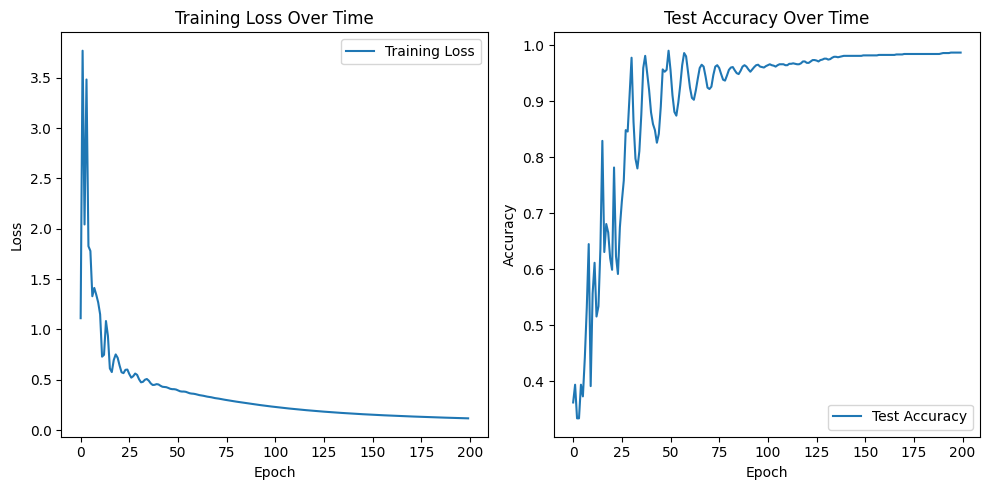

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy Over Time')
plt.tight_layout()
plt.show()

Accuracy: 0.9867
Precision: 0.9860
Recall: 0.9877
F1-Score: 0.9866


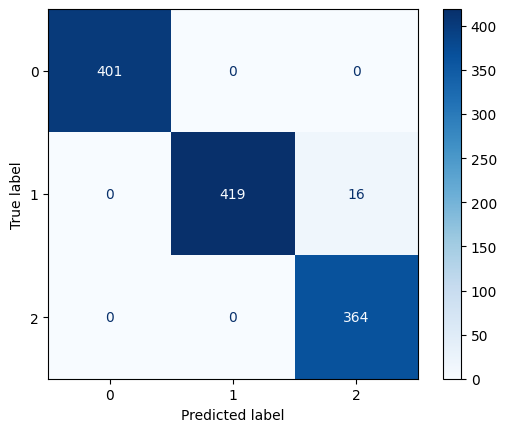

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate():
    model.eval()
    pred = model(data).argmax(dim=1)[data.test_mask]
    true_labels = data.y[data.test_mask]
    
    accuracy = int((pred == true_labels).sum()) / int(data.test_mask.sum())
    precision = precision_score(true_labels, pred, average='macro')
    recall = recall_score(true_labels, pred, average='macro')
    f1 = f1_score(true_labels, pred, average='macro')
    
    return accuracy, precision, recall, f1, pred, true_labels

# Get evaluation metrics
accuracy, precision, recall, f1, pred, true_labels = evaluate()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


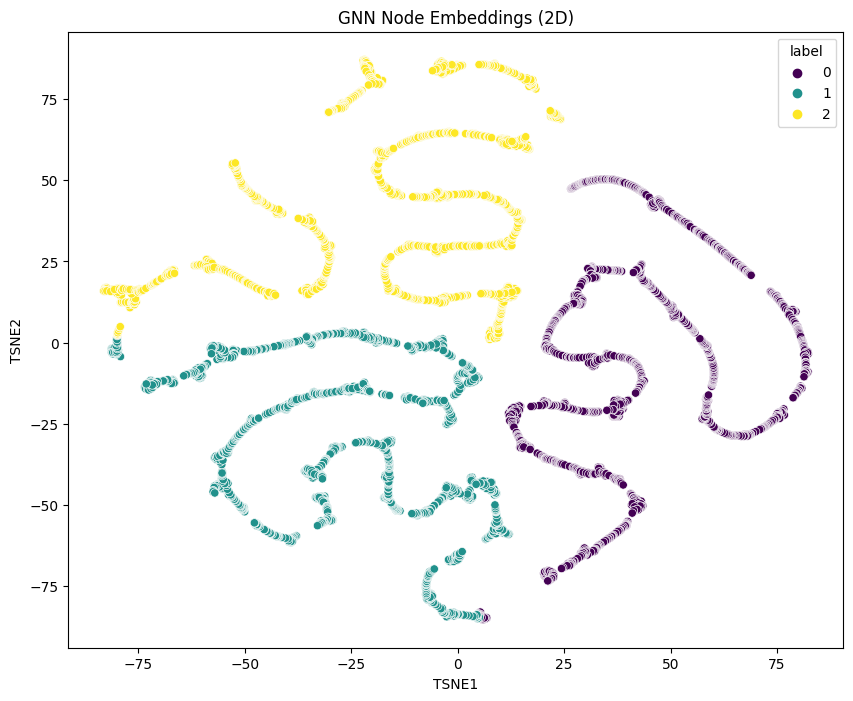

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_gnn_embeddings(model, data, reduction='tsne'):
    model.eval()
    # Pass data through the model to get embeddings
    with torch.no_grad():
        node_embeddings = model.conv1(data.x, data.edge_index)

    # Use t-SNE or PCA for dimensionality reduction
    if reduction == 'tsne':
        node_embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(node_embeddings.detach().cpu().numpy())
    elif reduction == 'pca':
        node_embeddings_2d = PCA(n_components=2).fit_transform(node_embeddings.detach().cpu().numpy())
    
    # Create a DataFrame for the reduced embeddings
    embeddings_df = pd.DataFrame(node_embeddings_2d, columns=['TSNE1', 'TSNE2'])
    embeddings_df['label'] = data.y.detach().cpu().numpy()
    
    # Plot the nodes with seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=embeddings_df, palette='viridis')
    plt.title('GNN Node Embeddings (2D)')
    plt.show()

# Call the visualization function with your model and data
visualize_gnn_embeddings(model, data)


Epoch 0, ANN Test Accuracy: 0.37
Epoch 10, ANN Test Accuracy: 0.415
Epoch 20, ANN Test Accuracy: 0.405
Epoch 30, ANN Test Accuracy: 0.43916666666666665
Epoch 40, ANN Test Accuracy: 0.43583333333333335
Epoch 50, ANN Test Accuracy: 0.43
Epoch 60, ANN Test Accuracy: 0.43416666666666665
Epoch 70, ANN Test Accuracy: 0.43916666666666665
Epoch 80, ANN Test Accuracy: 0.45
Epoch 90, ANN Test Accuracy: 0.4508333333333333
Epoch 100, ANN Test Accuracy: 0.43083333333333335
Epoch 110, ANN Test Accuracy: 0.4533333333333333
Epoch 120, ANN Test Accuracy: 0.45166666666666666
Epoch 130, ANN Test Accuracy: 0.4525
Epoch 140, ANN Test Accuracy: 0.4483333333333333
Epoch 150, ANN Test Accuracy: 0.4658333333333333
Epoch 160, ANN Test Accuracy: 0.4575
Epoch 170, ANN Test Accuracy: 0.45416666666666666
Epoch 180, ANN Test Accuracy: 0.43666666666666665
Epoch 190, ANN Test Accuracy: 0.44166666666666665


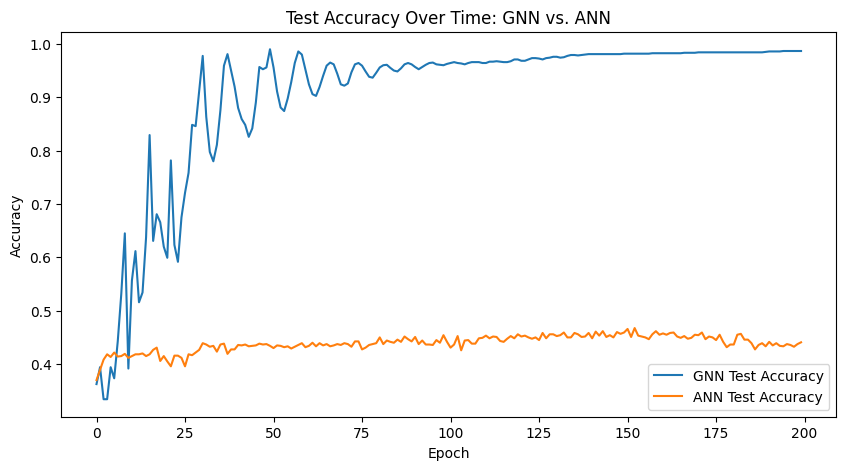

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Let's assume your features (X) and labels (y) are numpy arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the ANN model
ann_model = MLPClassifier(hidden_layer_sizes=(64, 64), random_state=42, max_iter=1, warm_start=True)

# Train and evaluate the ANN model
ann_accuracy_values = []
for epoch in range(200):
    ann_model.partial_fit(X_train_scaled, y_train, classes=np.unique(y))
    ann_pred = ann_model.predict(X_test_scaled)
    ann_acc = accuracy_score(y_test, ann_pred)
    ann_accuracy_values.append(ann_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, ANN Test Accuracy: {ann_acc}')

# Plot the accuracy of GNN and ANN on the same graph for comparison
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values, label='GNN Test Accuracy')
plt.plot(ann_accuracy_values, label='ANN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy Over Time: GNN vs. ANN')
plt.show()

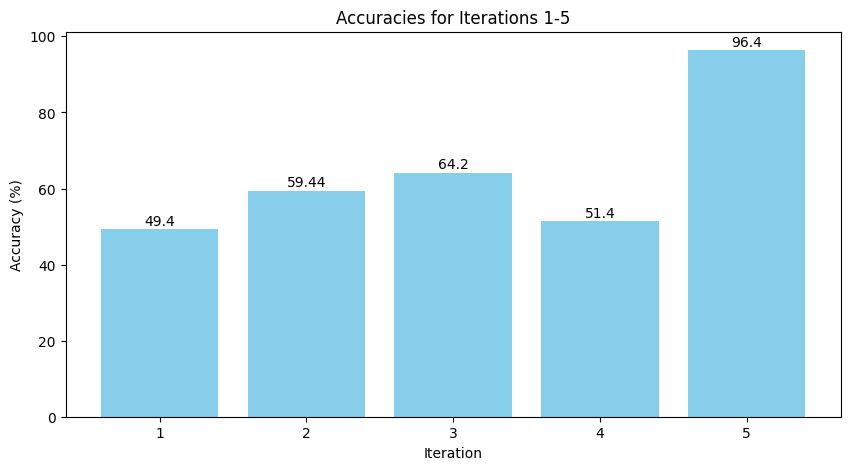

In [ ]:
# Given accuracies for iterations 1-5
iteration_accuracies = [49.4, 59.44, 64.2, 51.4, 96.4]

# Plot a bar chart of the accuracies
plt.figure(figsize=(10, 5))
iterations = range(1, 6)
plt.bar(iterations, iteration_accuracies, color='skyblue')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.xticks(iterations)
plt.title('Accuracies for Iterations 1-5')
for i, acc in enumerate(iteration_accuracies):
    plt.text(i + 1, acc + 1, str(acc), ha='center')  # Offset text for clarity
plt.show()
